In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import os
import boto3
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def maybe_pickle(data, filename, force=False):
    if os.path.exists(filename) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % filename)
    else:
        print('Pickling %s.' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', filename, ':', e)


def maybe_download(table, force=False):
    storage_file = table + ".pkl"
    if force or not os.path.exists(storage_file):
        data = data_retrieve(table)
        maybe_pickle(data, storage_file)
    return storage_file
        
def data_retrieve(table, page_size=100):
    """download data from table"""
    client = boto3.client('dynamodb')
    paginator = client.get_paginator('scan')

    counter = 0
    items = []
    for page in paginator.paginate(TableName=table, PaginationConfig={"PageSize": page_size}):
        items.extend(page["Items"])
        
        counter += 1
        if counter % 50 == 0:  # print debug every 50 pages
            print("next page. {}. Count {}. ScannedCount: {}".format(counter, page["Count"], page["ScannedCount"]))


    return items
    

In [ ]:
data_file = maybe_download("apthunt")
data = pickle.load(open(data_file, 'rb'))

In [ ]:
print("wow")

In [ ]:
# To go from dynamo format to python
from boto3.dynamodb import types

deserializer = types.TypeDeserializer()
python_data = [{k: deserializer.deserialize(v) for k,v in d.items()} for d in data]

In [7]:
del data

In [8]:
df = pd.DataFrame(python_data)

In [9]:
del python_data

In [10]:
# small cleanup of "simulated"
del df["FeedTitle"]
del df["FeedUrl"]
del df["PostContent"]
del df["PostPublished"]
del df["PostTitle"]
# delete parsed_notices. looks like it is the same
del df["parsed_notices"]
# no need for internal id
del df["intid"]
# no information from PostUrl
df["PostUrl"]
# no information from time added
del df["added"]

In [11]:
df.columns

Index(['parsed_postingtitletext', 'parsed_map_address', 'PostUrl',
       'parsed_price', 'parsed_price_text', 'parsed_housing',
       'parsed_data_longitude', 'parsed_attrs', 'parsed_district',
       'parsed_map_link', 'parsed_postingbody', 'parsed_page_head',
       'parsed_thumbs', 'parsed_titletextonly', 'parsed_data_latitude'],
      dtype='object')

In [12]:
# for col in df.columns:
#     print(col)
#     print(df[col].describe())
#     print(df[col].head())
#     print("=" * 60)

In [13]:
df.head()

,parsed_postingtitletext,parsed_map_address,PostUrl,parsed_price,parsed_price_text,parsed_housing,parsed_data_longitude,parsed_attrs,parsed_district,parsed_map_link,parsed_postingbody,parsed_page_head,parsed_thumbs,parsed_titletextonly,parsed_data_latitude
0,$3150 / 2br - 1300ft2 - Sunset Oaks Townhome- ...,1249 Crescent Terrace,https://sfbay.craigslist.org/sby/apa/d/sunset-...,3150,$3150,2br - 1300ft2,-122.026428,"[2BR / 2.5Ba, 1300ft2, available oct 6, townho...",sunnyvale,https://maps.google.com/?q=loc%3A+%31%32%34%39...,"Well designed and spacious 2 bedroom, 2 1/2 ba...",None,[https://images.craigslist.org/00Z0Z_5KZmIXxAc...,Sunset Oaks Townhome- 1249 Crescent Terrace - ...,37.353754
1,$1769 / 2br - 875ft2 - ❄ Pittsburg Apartment L...,2205 E Leland Rd,https://sfbay.craigslist.org/eby/apa/d/pittsbu...,1769,$1769,2br - 875ft2,-121.864673,"[2BR / 1Ba, 875ft2, apartment]","Pittsburg, CA",https://maps.google.com/?q=loc%3A+%32%32%30%35...,Diamond Hillside Apartment Homes offers spacio...,None,[https://images.craigslist.org/00c0c_505E4utDZ...,"❄ Pittsburg Apartment Living, Gated Community,...",38.008321
2,$3000 / 2br - 1800ft2 - 2 Bedroom 1 Bath 1 Car...,375 Pope Street,https://sfbay.craigslist.org/sfc/apa/d/2-bedro...,3000,$3000,2br - 1800ft2,-122.439706,"[2BR / 1Ba, 1800ft2, available oct 1, house, l...",excelsior / outer mission,https://maps.google.com/?q=loc%3A+%33%37%35+Po...,clean 2 Bedroom 1 full bathroom 1 car garage. ...,None,[https://images.craigslist.org/00G0G_2bsd96Q2m...,2 Bedroom 1 Bath 1 Car Garage House,37.710526
3,$2395 / 2br - Lovely 2bd/2ba + den close to fr...,Maricopa at Chilpancingo,https://sfbay.craigslist.org/eby/apa/d/lovely-...,2395,$2395,2br,-122.070774,"[2BR / 2Ba, available jun 19, apartment, w/d h...",concord / pleasant hill / martinez,https://maps.google.com/?q=loc%3A+Maricopa+at+...,Lovely 2bd/2ba + den close to freeway in Pleas...,None,[https://images.craigslist.org/00J0J_bEViS29iF...,Lovely 2bd/2ba + den close to freeway in Pleas...,37.973522
4,"$4342 / 2br - 1116ft2 - Murphy Park, 2x2, 2 En...",355 East Evelyn Ave. near Carroll Street,https://sfbay.craigslist.org/sby/apa/d/sunnyva...,4342,$4342,2br - 1116ft2,-122.027282,"[2BR / 2Ba, 1116ft2, cats are OK - purrr, dogs...",sunnyvale,https://www.google.com/maps/preview/@37.376987...,"Villa Del Sol\n355 E EVELYN AVE, Sunnyvale, CA...",None,[https://images.craigslist.org/00x0x_9tzT9mvEh...,"Murphy Park, 2x2, 2 Entrances, 24Hr. Gym, BBQ,...",37.376987


In [14]:
def prepare_data(df):
    new  = pd.DataFrame()
    new["latitude"] = df["parsed_data_latitude"]
    new["longitude"] = df["parsed_data_longitude"]
    new["district"] = df["parsed_district"].map(lambda s: s.strip("()") if isinstance(s, str) else s)

    new["price"] = df["parsed_price"].map(lambda x: float(x) if x else x)
    
    # # defined parts
    # new["latitude_defined"] = df["parsed_data_latitude"].notna()
    # new["longitude_defined"] = df["parsed_data_longitude"].notna()
    # new["district_defined"] = df["parsed_district"].notna()
    
    return new

In [15]:
prepare_data(df)

,latitude,longitude,district,price
0,37.353754,-122.026428,sunnyvale,3150
1,38.008321,-121.864673,"Pittsburg, CA",1769
2,37.710526,-122.439706,excelsior / outer mission,3000
3,37.973522,-122.070774,concord / pleasant hill / martinez,2395
4,37.376987,-122.027282,sunnyvale,4342
...,...,...,...,...
619284,37.472002,-122.216147,Redwood City,3890
619285,37.8002,-122.4091,north beach / telegraph hill,9900
619286,37.7015,-122.0782,hayward / castro valley,2650
619287,37.337841,-121.978369,santa clara,2195


In [16]:
df[df['parsed_price'] == 7072899529].values


array([['$7072899529 / 2br - 516ft2 - GORGEOUS 2X2 WITH FULL SIZE WASHER & DRYER (napa county) hide this posting unhide',
        '5500 Eucalyptus Drive',
        'https://sfbay.craigslist.org/nby/apa/d/gorgeous-2x2-with-full-size/6745199759.html',
        Decimal('7072899529'), '$7072899529', '2br - 516ft2',
        Decimal('-122.256082'),
        list(['2BR / 2Ba', '516ft2', 'available nov 9', 'cats are OK - purrr', 'dogs are OK - wooof', 'apartment', 'w/d in unit', 'carport']),
        'napa county',
        'https://maps.google.com/?q=loc%3A+%35%35%30%30+Eucalyptus+Drive+American+Canyon+CA+US',
        '2 \xa0bedroom 2 bath 1085Sq.Ft. $2,253 - $2,624/mo\nThe Lodge At Napa Junction\nCALL US TODAY: show contact info x516\nDESCRIPTION:\nExperience the best in luxury apartment living in American Canyon, thanks to this two-bedroom, two-bathroom floor plan from The Lodge at Napa Junction. Along with a fireplace in select homes, the layout includes a built-in desk nook in the kitchen and 

In [17]:
p = df["parsed_price"].dropna().map(float)
p.describe()


count    6.150750e+05
mean     1.614827e+04
std      9.031118e+06
min      0.000000e+00
25%      2.095000e+03
50%      2.681000e+03
75%      3.500000e+03
max      7.072900e+09
Name: parsed_price, dtype: float64

In [18]:
p.quantile([0.5, 0.75, 0.8, 0.9, 1.0])

0.50    2.681000e+03
0.75    3.500000e+03
0.80    3.725000e+03
0.90    4.500000e+03
1.00    7.072900e+09
Name: parsed_price, dtype: float64

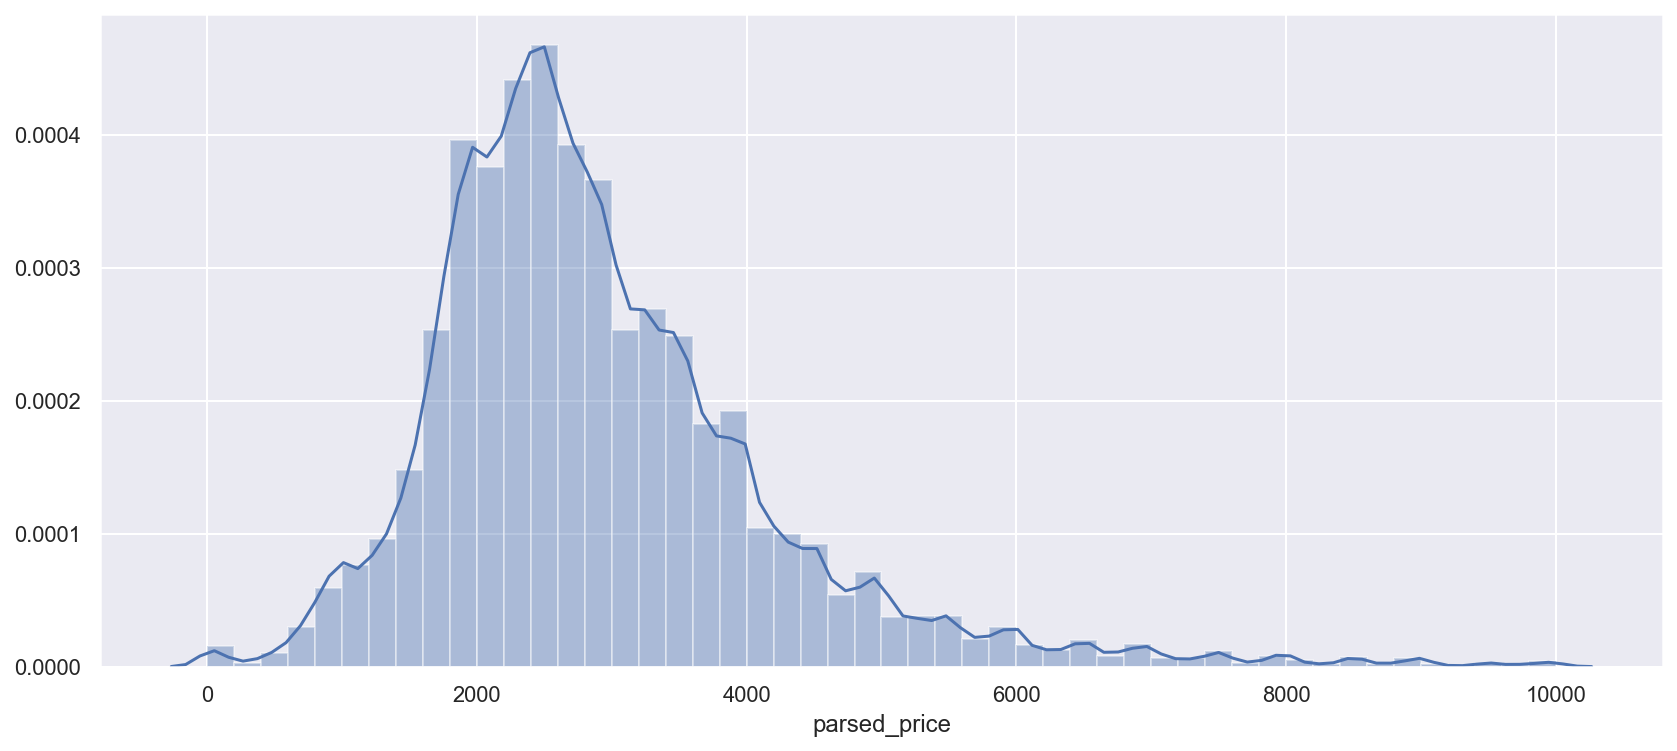

In [19]:
sns.set(color_codes=True)
plt.figure(figsize=(14, 6))

g = sns.distplot(p[p < 10000]);
# g = sns.distplot(p);

In [20]:
p[p < 60000].describe()

count    614915.000000
mean       2989.235462
std        1703.579579
min           0.000000
25%        2095.000000
50%        2681.000000
75%        3500.000000
max       59000.000000
Name: parsed_price, dtype: float64

In [21]:
p[p<1000].sort_values()


309060      0.0
574945      0.0
389601      0.0
269427      0.0
239172      0.0
          ...  
54167     999.0
427095    999.0
67253     999.0
135649    999.0
513635    999.0
Name: parsed_price, Length: 14340, dtype: float64

In [22]:
pid = 344311
print(df.iloc[pid])
print(df.iloc[pid]["PostUrl"])
print(df.iloc[pid]["parsed_thumbs"])

parsed_postingtitletext    $2495 / 2br - 850ft2 - Freshly updated 2 Bed 1...
parsed_map_address                       1820 Welch Avenue Apt 4 near Senter
PostUrl                    https://sfbay.craigslist.org/sby/apa/d/san-jos...
parsed_price                                                            2495
parsed_price_text                                                      $2495
parsed_housing                                                  2br - 850ft2
parsed_data_longitude                                            -121.856276
parsed_attrs               [2BR / 1Ba, 850ft2, available dec 19, applicat...
parsed_district                                            san jose downtown
parsed_map_link            https://www.google.com/maps/preview/@37.317553...
parsed_postingbody         Nice Townhouse Style Apartment near Kelly Park...
parsed_page_head                                                        None
parsed_thumbs              [https://images.craigslist.org/00909_51bDDpp9y...

In [23]:
maybe_pickle(prepare_data(df), "train.pd")

Pickling train.pd.


In [24]:
df["parsed_data_latitude"].dropna().astype(float).sort_values()

420490   -37.850922
76712    -36.636071
110089   -32.789807
562445   -32.108455
226422   -14.283544
            ...    
162631    49.166579
114008    50.238709
115944    61.186929
559651    66.361038
256909    66.361038
Name: parsed_data_latitude, Length: 586382, dtype: float64